In [1]:
# https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [2]:
# https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/372780

In [3]:
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [9]:
from lightgbm import LGBMRegressor

In [10]:
from sklearn.metrics import mean_squared_error

# 1. Load data

In [11]:
df = pd.read_csv('PJME_hourly.csv')

In [12]:
df.sample(5)

,Datetime,PJME_MW
132322,2017-11-26 12:00:00,25839.0
41683,2006-03-30 06:00:00,27225.0
38584,2006-08-06 02:00:00,30537.0
10798,2003-10-07 02:00:00,23030.0
63123,2009-10-19 19:00:00,33135.0


In [13]:
df.shape

(145366, 2)

# 2. Check data quality

data type

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [15]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [16]:
df.sort_values('Datetime', inplace=True)

unique value

In [17]:
df.shape

(145366, 2)

In [18]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Datetime
Unique value:  <DatetimeArray>
['2002-01-01 01:00:00', '2002-01-01 02:00:00', '2002-01-01 03:00:00',
 '2002-01-01 04:00:00', '2002-01-01 05:00:00', '2002-01-01 06:00:00',
 '2002-01-01 07:00:00', '2002-01-01 08:00:00', '2002-01-01 09:00:00',
 '2002-01-01 10:00:00',
 ...
 '2018-08-02 15:00:00', '2018-08-02 16:00:00', '2018-08-02 17:00:00',
 '2018-08-02 18:00:00', '2018-08-02 19:00:00', '2018-08-02 20:00:00',
 '2018-08-02 21:00:00', '2018-08-02 22:00:00', '2018-08-02 23:00:00',
 '2018-08-03 00:00:00']
Length: 145362, dtype: datetime64[ns]
Count unique value:  145362
----------
Columns name:  PJME_MW
Unique value:  [30393. 29265. 28357. ... 44094. 40666. 46816.]
Count unique value:  28441
----------


handle duplicate

In [19]:
df = df.groupby('Datetime')['PJME_MW'].mean().reset_index()

In [20]:
df

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145357,2018-08-02 20:00:00,44057.0
145358,2018-08-02 21:00:00,43256.0
145359,2018-08-02 22:00:00,41552.0
145360,2018-08-02 23:00:00,38500.0


check missing hour

In [21]:
start_timestamp = df['Datetime'].min()

In [22]:
end_timestamp = df['Datetime'].max()

In [23]:
hourly_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

In [24]:
df_hourly = pd.DataFrame(hourly_timestamps, columns=['Datetime'])

In [25]:
df_hourly = pd.merge(df_hourly, df, on = 'Datetime', how = 'left')

In [26]:
df_hourly

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


In [27]:
df = df_hourly

missing value

In [28]:
df.isnull().sum()

Datetime     0
PJME_MW     30
dtype: int64

In [29]:
df[df.isnull().any(axis=1)]

,Datetime,PJME_MW
2306,2002-04-07 03:00:00,NaN
7177,2002-10-27 02:00:00,NaN
11042,2003-04-06 03:00:00,NaN
15913,2003-10-26 02:00:00,NaN
19778,2004-04-04 03:00:00,NaN
24817,2004-10-31 02:00:00,NaN
28514,2005-04-03 03:00:00,NaN
33553,2005-10-30 02:00:00,NaN
37250,2006-04-02 03:00:00,NaN
42289,2006-10-29 02:00:00,NaN


In [30]:
df['PJME_MW'] = df['PJME_MW'].fillna(method='ffill')

In [31]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

zero value

In [32]:
(df == 0).sum()

Datetime    0
PJME_MW     0
dtype: int64

blank value

In [33]:
(df == '').sum()

Datetime    0
PJME_MW     0
dtype: int64

copy for prediction

In [34]:
df_for_predict = df.copy()

# 3. Exploratory data analysis (EDA)

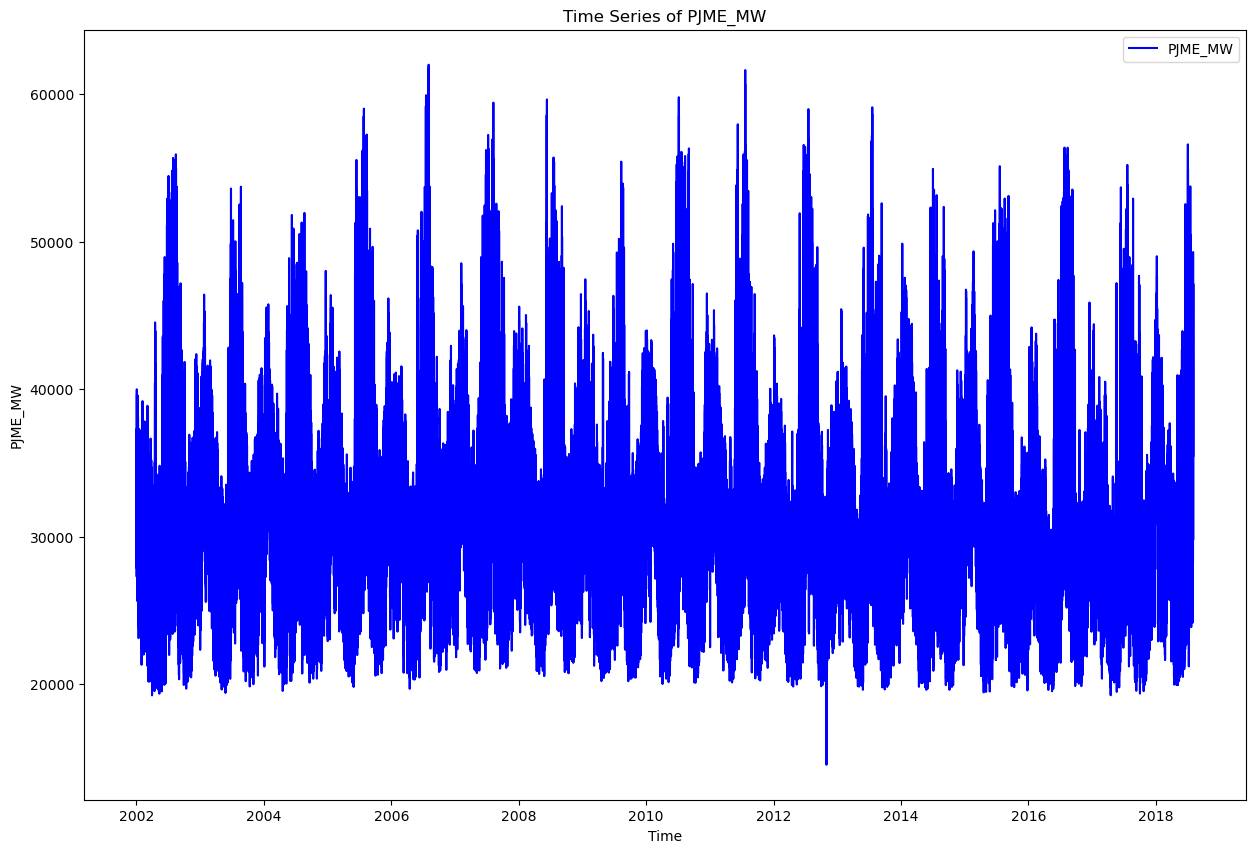

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['PJME_MW'], label='PJME_MW', color='blue')
plt.xlabel('Time')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW')
plt.show()

<Figure size 1500x2000 with 0 Axes>

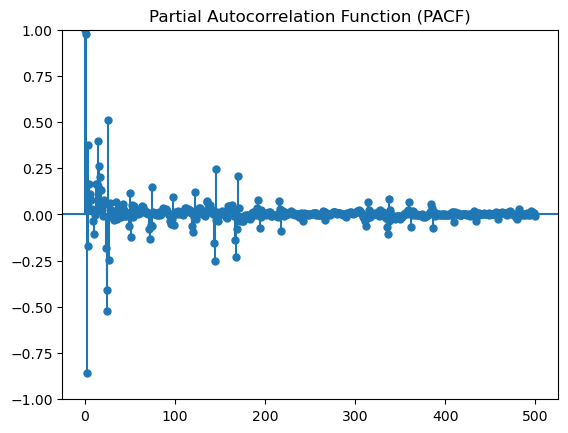

In [36]:
plt.figure(figsize=(15, 20))
plot_pacf(df['PJME_MW'], lags=500)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1500x2000 with 0 Axes>

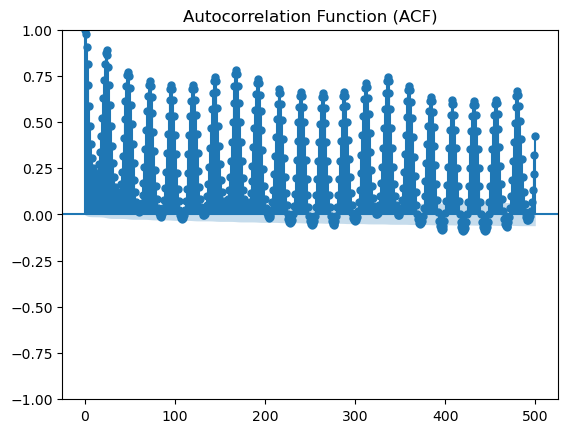

In [37]:
plt.figure(figsize=(15, 20))
plot_acf(df['PJME_MW'], lags=500)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# 3. Feature engineering

save for prediction

In [38]:
df

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


In [39]:
df_predict = df

datetime features

In [40]:
def datetime_feature_extraction(df):
    # hour
    df['hour'] = df['Datetime'].dt.hour
    # day
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    # week
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week
    df['weekofmonth'] = np.ceil(df['dayofmonth'] / 7).astype(int)
    # month
    df['month'] = df['Datetime'].dt.month
    # year
    df['year'] = (df['Datetime'].dt.year)-2002
    # other attributes
    df['is_weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
    df['is_month_start'] = df['Datetime'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Datetime'].dt.is_month_end.astype(int)
    df['is_year_start'] = df['Datetime'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['Datetime'].dt.is_year_end.astype(int)

    return df

In [41]:
df = datetime_feature_extraction(df)

In [42]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,weekofyear,weekofmonth,month,year,is_weekend,is_month_start,is_month_end,is_year_start,is_year_end
0,2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,1,0,0,1,0,1,0
1,2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,1,0,0,1,0,1,0
2,2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,1,0,0,1,0,1,0
3,2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,1,0,0,1,0,1,0
4,2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,31,1,8,16,0,0,0,0,0
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,31,1,8,16,0,0,0,0,0
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,31,1,8,16,0,0,0,0,0
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,31,1,8,16,0,0,0,0,0


lag features

In [43]:
def lag_feature_extraction(df):
    lag_hours = [1, 2, 3, 6, 12, 24, 72, 120, 144, 720]

    for lag in lag_hours:
        df[f'PJME_MW_lag_{lag}h'] = df['PJME_MW'].shift(periods=lag)
    df.fillna(method='bfill', inplace=True)

    return df

In [44]:
df = lag_feature_extraction(df)

In [45]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,weekofyear,weekofmonth,month,year,...,PJME_MW_lag_1h,PJME_MW_lag_2h,PJME_MW_lag_3h,PJME_MW_lag_6h,PJME_MW_lag_12h,PJME_MW_lag_24h,PJME_MW_lag_72h,PJME_MW_lag_120h,PJME_MW_lag_144h,PJME_MW_lag_720h
0,2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,1,0,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
1,2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,1,0,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
2,2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,1,0,...,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
3,2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,1,0,...,28357.0,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
4,2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,1,0,...,27899.0,28357.0,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,31,1,8,16,...,45641.0,46760.0,46816.0,46534.0,35645.0,46912.0,36166.0,40498.0,40883.0,49244.0
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,31,1,8,16,...,44057.0,45641.0,46760.0,47154.0,37810.0,45985.0,35899.0,38869.0,39275.0,47292.0
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,31,1,8,16,...,43256.0,44057.0,45641.0,46989.0,39902.0,44094.0,34879.0,37375.0,37618.0,45506.0
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,31,1,8,16,...,41552.0,43256.0,44057.0,46816.0,42189.0,40666.0,32303.0,34687.0,35038.0,42437.0


rolling windows

In [46]:
def rolling_feature_extraction(df):
    rolling_periods = [24, 72, 120, 144, 720]

    for period in rolling_periods:
        # Calculate the rolling mean with a lag of 1 period
        df[f'PJME_MW_MA_{period}h_mean'] = df['PJME_MW'].rolling(window=period).mean().shift(1)
        # Calculate the rolling min with a lag of 1 period
        df[f'PJME_MW_MA_{period}h_min'] = df['PJME_MW'].rolling(window=period).min().shift(1)
        # Calculate the rolling max with a lag of 1 period
        df[f'PJME_MW_MA_{period}h_max'] = df['PJME_MW'].rolling(window=period).max().shift(1)
        # Calculate the rolling standard deviation with a lag of 1 period
        df[f'PJME_MW_MA_{period}h_std'] = df['PJME_MW'].rolling(window=period).std().shift(1)

    return df

In [47]:
df = rolling_feature_extraction(df)

In [48]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,weekofyear,weekofmonth,month,year,...,PJME_MW_MA_120h_max,PJME_MW_MA_120h_std,PJME_MW_MA_144h_mean,PJME_MW_MA_144h_min,PJME_MW_MA_144h_max,PJME_MW_MA_144h_std,PJME_MW_MA_720h_mean,PJME_MW_MA_720h_min,PJME_MW_MA_720h_max,PJME_MW_MA_720h_std
0,2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,31,1,8,16,...,49308.0,6733.763205,35395.451389,24161.0,49308.0,6632.572772,36202.493056,21211.0,53764.0,7286.979834
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,31,1,8,16,...,49308.0,6763.450134,35417.493056,24161.0,49308.0,6656.168788,36195.288889,21211.0,53764.0,7276.625275
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,31,1,8,16,...,49308.0,6793.095370,35445.138889,24161.0,49308.0,6680.525467,36189.683333,21211.0,53764.0,7269.616216
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,31,1,8,16,...,49308.0,6812.784773,35472.458333,24161.0,49308.0,6697.495663,36184.191667,21211.0,53764.0,7264.059984


drop na

In [49]:
df = df.dropna()

In [50]:
df.isna().sum()

Datetime                0
PJME_MW                 0
hour                    0
dayofweek               0
dayofmonth              0
dayofyear               0
weekofyear              0
weekofmonth             0
month                   0
year                    0
is_weekend              0
is_month_start          0
is_month_end            0
is_year_start           0
is_year_end             0
PJME_MW_lag_1h          0
PJME_MW_lag_2h          0
PJME_MW_lag_3h          0
PJME_MW_lag_6h          0
PJME_MW_lag_12h         0
PJME_MW_lag_24h         0
PJME_MW_lag_72h         0
PJME_MW_lag_120h        0
PJME_MW_lag_144h        0
PJME_MW_lag_720h        0
PJME_MW_MA_24h_mean     0
PJME_MW_MA_24h_min      0
PJME_MW_MA_24h_max      0
PJME_MW_MA_24h_std      0
PJME_MW_MA_72h_mean     0
PJME_MW_MA_72h_min      0
PJME_MW_MA_72h_max      0
PJME_MW_MA_72h_std      0
PJME_MW_MA_120h_mean    0
PJME_MW_MA_120h_min     0
PJME_MW_MA_120h_max     0
PJME_MW_MA_120h_std     0
PJME_MW_MA_144h_mean    0
PJME_MW_MA_1

correlation

In [51]:
corr = df.corr()

<Axes: >

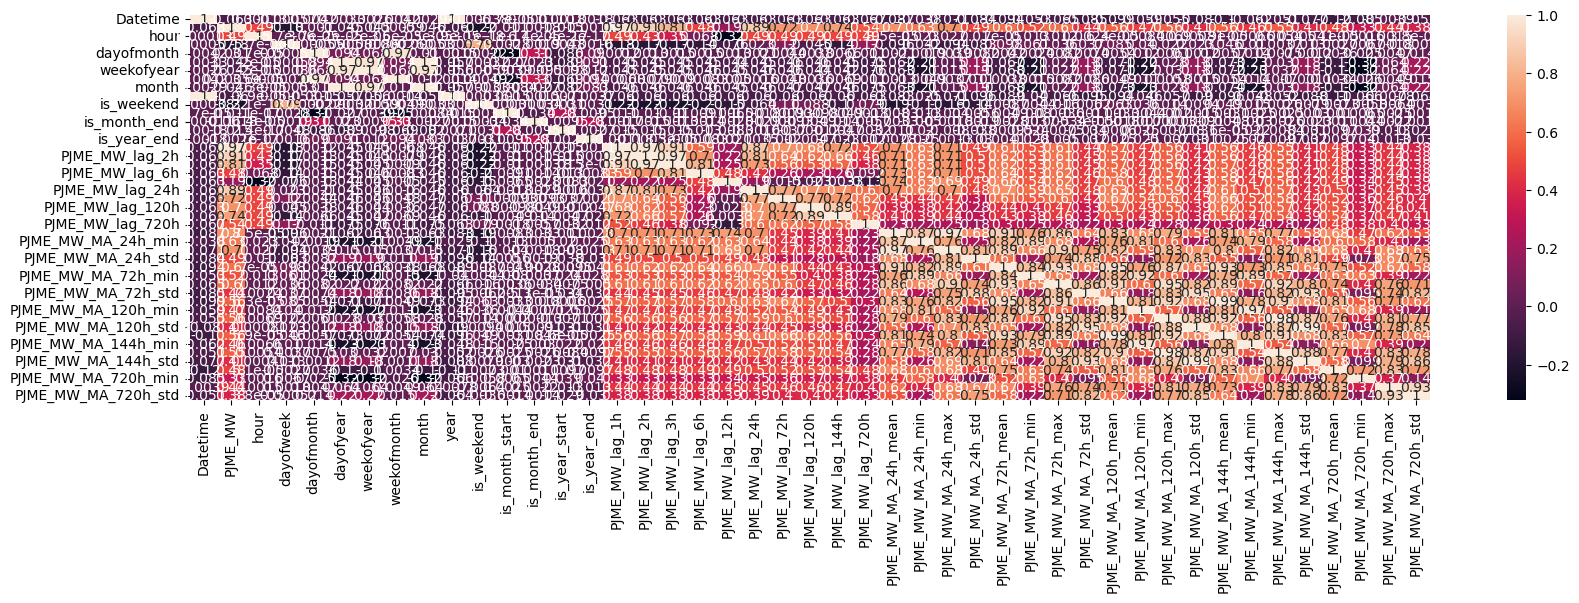

In [52]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [53]:
corr_churn_table = corr['PJME_MW'].sort_values(ascending=False)

In [54]:
corr_churn_table.head(20)

PJME_MW                 1.000000
PJME_MW_lag_1h          0.974845
PJME_MW_lag_2h          0.907794
PJME_MW_lag_24h         0.891501
PJME_MW_lag_3h          0.813001
PJME_MW_lag_144h        0.744783
PJME_MW_lag_72h         0.720814
PJME_MW_MA_24h_max      0.703989
PJME_MW_lag_120h        0.699959
PJME_MW_MA_24h_mean     0.696679
PJME_MW_MA_24h_min      0.625908
PJME_MW_MA_72h_mean     0.604405
PJME_MW_MA_72h_max      0.602648
PJME_MW_MA_120h_mean    0.562738
PJME_MW_MA_144h_mean    0.558948
PJME_MW_MA_120h_max     0.557644
PJME_MW_MA_144h_max     0.547788
PJME_MW_lag_720h        0.538494
PJME_MW_MA_72h_min      0.521790
PJME_MW_MA_24h_std      0.486524
Name: PJME_MW, dtype: float64

In [55]:
corr_churn_abs_table = corr['PJME_MW'].abs().sort_values(ascending=False)

In [56]:
corr_churn_abs_table.head(20)

PJME_MW                 1.000000
PJME_MW_lag_1h          0.974845
PJME_MW_lag_2h          0.907794
PJME_MW_lag_24h         0.891501
PJME_MW_lag_3h          0.813001
PJME_MW_lag_144h        0.744783
PJME_MW_lag_72h         0.720814
PJME_MW_MA_24h_max      0.703989
PJME_MW_lag_120h        0.699959
PJME_MW_MA_24h_mean     0.696679
PJME_MW_MA_24h_min      0.625908
PJME_MW_MA_72h_mean     0.604405
PJME_MW_MA_72h_max      0.602648
PJME_MW_MA_120h_mean    0.562738
PJME_MW_MA_144h_mean    0.558948
PJME_MW_MA_120h_max     0.557644
PJME_MW_MA_144h_max     0.547788
PJME_MW_lag_720h        0.538494
PJME_MW_MA_72h_min      0.521790
PJME_MW_MA_24h_std      0.486524
Name: PJME_MW, dtype: float64

# 4. Model

In [57]:
df

,Datetime,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,weekofyear,weekofmonth,month,year,...,PJME_MW_MA_120h_max,PJME_MW_MA_120h_std,PJME_MW_MA_144h_mean,PJME_MW_MA_144h_min,PJME_MW_MA_144h_max,PJME_MW_MA_144h_std,PJME_MW_MA_720h_mean,PJME_MW_MA_720h_min,PJME_MW_MA_720h_max,PJME_MW_MA_720h_std
720,2002-01-31 01:00:00,23559.0,1,3,31,31,5,5,1,0,...,34181.0,3340.737505,28657.416667,21320.0,34438.0,3467.993748,31090.741667,21320.0,40002.0,3963.736702
721,2002-01-31 02:00:00,22734.0,2,3,31,31,5,5,1,0,...,34181.0,3365.291266,28649.972222,21320.0,34438.0,3477.833977,31081.250000,21320.0,40002.0,3973.580071
722,2002-01-31 03:00:00,22363.0,3,3,31,31,5,5,1,0,...,34181.0,3394.650885,28642.791667,21320.0,34438.0,3489.033490,31072.179167,21320.0,40002.0,3985.169485
723,2002-01-31 04:00:00,22487.0,4,3,31,31,5,5,1,0,...,34181.0,3426.225129,28634.645833,21320.0,34438.0,3502.383433,31063.854167,21320.0,40002.0,3997.092253
724,2002-01-31 05:00:00,23087.0,5,3,31,31,5,5,1,0,...,34181.0,3454.197094,28626.409722,21320.0,34438.0,3515.502611,31056.337500,21320.0,40002.0,4008.125642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145387,2018-08-02 20:00:00,44057.0,20,3,2,214,31,1,8,16,...,49308.0,6733.763205,35395.451389,24161.0,49308.0,6632.572772,36202.493056,21211.0,53764.0,7286.979834
145388,2018-08-02 21:00:00,43256.0,21,3,2,214,31,1,8,16,...,49308.0,6763.450134,35417.493056,24161.0,49308.0,6656.168788,36195.288889,21211.0,53764.0,7276.625275
145389,2018-08-02 22:00:00,41552.0,22,3,2,214,31,1,8,16,...,49308.0,6793.095370,35445.138889,24161.0,49308.0,6680.525467,36189.683333,21211.0,53764.0,7269.616216
145390,2018-08-02 23:00:00,38500.0,23,3,2,214,31,1,8,16,...,49308.0,6812.784773,35472.458333,24161.0,49308.0,6697.495663,36184.191667,21211.0,53764.0,7264.059984


In [58]:
df_for_predict

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145387,2018-08-02 20:00:00,44057.0
145388,2018-08-02 21:00:00,43256.0
145389,2018-08-02 22:00:00,41552.0
145390,2018-08-02 23:00:00,38500.0


train-test split

In [59]:
df = df.sort_values('Datetime')

In [60]:
df.drop(columns=['Datetime'], inplace=True)

In [61]:
X = df.drop(columns=['PJME_MW'])
y = df['PJME_MW']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model

In [63]:
tscv = TimeSeriesSplit(n_splits = 5)

In [64]:
model = LGBMRegressor()

In [65]:
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [66]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [67]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

evaluate

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)

In [ ]:
-mse

In [ ]:
***

# 5. Predict

In [ ]:
df_for_predict

In [ ]:
last_timestamp = df_for_predict['Datetime'].max()

In [ ]:
last_timestamp

In [ ]:
future_timestamps = [last_timestamp + pd.Timedelta(hours=i) for i in range(1, 24*365)]

In [ ]:
future_predictions = []

In [ ]:
# recursive

In [ ]:
for timestamp in future_timestamps:
    # Create features for the current timestamp
    df_feature = pd.DataFrame([[timestamp, None]], columns=['Datetime', 'PJME_MW'])
    future_predictions = pd.concat([df_for_predict, df_feature], ignore_index=True, sort=False)
    df_for_predict_feature = datetime_feature_extraction(future_predictions)
    df_for_predict_feature = lag_feature_extraction(df_for_predict_feature)
    df_for_predict_feature = rolling_feature_extraction(df_for_predict_feature)
    df_for_predict_feature = df_for_predict_feature.tail(1).iloc[:,2:]
    y_predicted = grid_search.predict(df_for_predict_feature)[0]
    # Predict
    df_predicted = pd.DataFrame([[timestamp, y_predicted]], columns=['Datetime', 'PJME_MW'])
    # Append
    df_for_predict = pd.concat([df_for_predict, df_predicted], ignore_index=True, sort=False)
    # # Print
    # print(timestamp, y_predicted)

In [ ]:
df_for_predict['predict_flag'] = np.where(df_for_predict['Datetime'] <= last_timestamp, 'Actual', 'Predicted')

In [ ]:
df_for_predict

In [ ]:
plt.figure(figsize=(10, 6))
actual_data = df_for_predict[df_for_predict['predict_flag'] == 'Actual']
predicted_data = df_for_predict[df_for_predict['predict_flag'] == 'Predicted']
plt.plot(actual_data['Datetime'], actual_data['PJME_MW'], color='blue', label='Actual')
plt.plot(predicted_data['Datetime'], predicted_data['PJME_MW'], color='orange', label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.title('PJME_MW over Time')
plt.legend()
plt.show()